In [66]:
# we need a max intensity projection to see how the 3D data looks like!

In [2]:
import matplotlib.pylab as plt
import numpy as np

import pylattice.functions.TiffProcessing as pl

Generate particle images and microscopy images
----------
**Simulation setup / Ground truth**: 
* xyz Area of 50,000 x 50,000 x 50,000 nanometers.
* 1000 particles.
* remember: in tiff files, the first dimension is z!


In [68]:
def simulate_particles(N=1000, size=50000, kamp=0.5, Damp=0.01 ):
    """ Simulate particles
    
    Parameters
    ----------
    N : number of particles
    size : xyz size in nanometers
    Damp : amplitude random component
    kamp : amplitude constant component
    
    """
    X = np.zeros((1, N, 3))  # particle-index, xyz
    A = np.zeros((1, N))
    # initialize
    X[0] = size * np.random.rand(N, 3)
    # simulate

    i = 0
    # constrain to bounding box
    X[i] = X[i] % size
    
    # update amplitudes
    A[i] = kamp + Damp * np.random.randn(N)

    # constrain to [0, 1]
    A[i] = np.absolute(A[i])
    A[i] = np.maximum(np.minimum(A[i], 1.0), 0.0)

    
    return X, A

In [69]:
# relationship between resolution (FWHM) and sigma
standard_resolution = 100 #nm
const = 2
standard_sigma = const*standard_resolution / (2.0 * np.sqrt(2*np.log(2)))
standard_sigma_z = 2*standard_sigma
print("standard_sigma {}".format(standard_sigma))
print("standard_sigma_z {}".format(standard_sigma_z))

standard_sigma 84.93218002880191
standard_sigma_z 169.86436005760382


In [112]:
def microscope(trajs_X, trajs_A, 
               size=np.array([50000,50000,50000]), 
               gridsize=np.array([200,100,100]), 
               psf_width=np.array([standard_sigma,standard_sigma,standard_sigma_z]), 
               noise_mean=0.0, noise_sigma=0.1):
    """ Simulate a microscope images given a set of particles
    
    Parameters
    ----------
    trajs : numpy array (1 x N x 3)
        N particle in 3D
    size : float
        Microscope image size, in nanometers
    gridsize : float
        xyz-Size of one microscope pixel, in nanometers
    psf_width : float
        width of the point spread function, in nanometers
    noise : float
        Shot noise intensity

    
    """
    
    # make grid
    _, N, _ = trajs_X.shape
    
    ngrid = (size / gridsize).astype(int)
    c_grid_x = np.linspace(0, size[0]-gridsize[0], num=ngrid[0]) + 0.5*gridsize[0]
    c_grid_y = np.linspace(0, size[1]-gridsize[1], num=ngrid[1]) + 0.5*gridsize[1]
    c_grid_z = np.linspace(0, size[2]-gridsize[2], num=ngrid[2]) + 0.5*gridsize[2]
    
    n_neighbors_x = int(3 * psf_width[0] / gridsize[0]) + 1
    n_neighbors_y = int(3 * psf_width[1] / gridsize[1]) + 1
    n_neighbors_z = int(3 * psf_width[2] / gridsize[2]) + 1
    
    print("ngrid {}".format(ngrid))
    X = np.zeros((1, ngrid[0], ngrid[1], ngrid[2]))
    
    # spread on grid
    t=0
    for i in range(N):
        # find central grid cell
        ix = int((trajs_X[t, i, 0] / size[0]) * ngrid[0])
        iy = int((trajs_X[t, i, 1] / size[1]) * ngrid[1])
        iz = int((trajs_X[t, i, 2] / size[2]) * ngrid[2])
        # iterate over valid neighbors
        #print(i)
        for kx in range(max(0, ix - n_neighbors_x), min(ngrid[0], ix + n_neighbors_x)):
            for ky in range(max(0, iy - n_neighbors_y), min(ngrid[1], iy + n_neighbors_y)):
                for kz in range(max(0, iz - n_neighbors_z), min(ngrid[2], iz + n_neighbors_z)):

                    d2_x = (trajs_X[t, i, 0] - c_grid_x[kx])**2
                    d2_y = (trajs_X[t, i, 1] - c_grid_y[ky])**2
                    d2_z = (trajs_X[t, i, 2] - c_grid_z[kz])**2
                    
                    value = trajs_A[t, i] * np.exp(-d2_x / (2*psf_width[0]*psf_width[0])) \
                                          * np.exp(-d2_y / (2*psf_width[1]*psf_width[1])) \
                                          * np.exp(-d2_z / (2*psf_width[2]*psf_width[2]))                        
                    
                    X[t, kx, ky, kz] += value
                    
    # add noise
    # get a sample from a normal distribution
    noise = noise_mean + noise_sigma * np.absolute(np.random.randn(1, ngrid[0], ngrid[1], ngrid[2]))
    noise = np.maximum(np.minimum(noise, 1.0), 0.0)
    X += noise
    return X

In [113]:
imageSize = np.array([50000,50000,50000]) #50µm cube
scope_resolution = np.array([200,100,100]) #100nm xy, 200z resolution
scope_psf_width = np.array([standard_sigma_z,standard_sigma,standard_sigma])
numberOfParticles = 500
particle_Damp=0.01 # particle amplitude random component
particle_kamp=0.5 # particle amplitude
trajs_X, trajs_A = simulate_particles(N=numberOfParticles, size=imageSize,Damp=particle_Damp, kamp=particle_kamp)
#print(trajs_X)
#print(trajs_A)

In [123]:
noise_mean=0.0
noise_sigma=0.1
X = np.zeros((1, ngrid[0], ngrid[1], ngrid[2]))
noise = noise_mean + noise_sigma * np.absolute(np.random.randn(1, ngrid[0], ngrid[1], ngrid[2]))
noise = np.maximum(np.minimum(noise, 1.0), 0.0)

pl.maxIntensityProjection(noise)

TypeError: Invalid dimensions for image data

In [117]:
scope_noise_mean = 0.5
scope_noise_sigma = 0.01

X = microscope(trajs_X, trajs_A, size=imageSize, 
               gridsize=scope_resolution, psf_width=scope_psf_width, noise_mean=scope_noise_mean, noise_sigma=scope_noise_sigma)


ngrid [250 500 500]


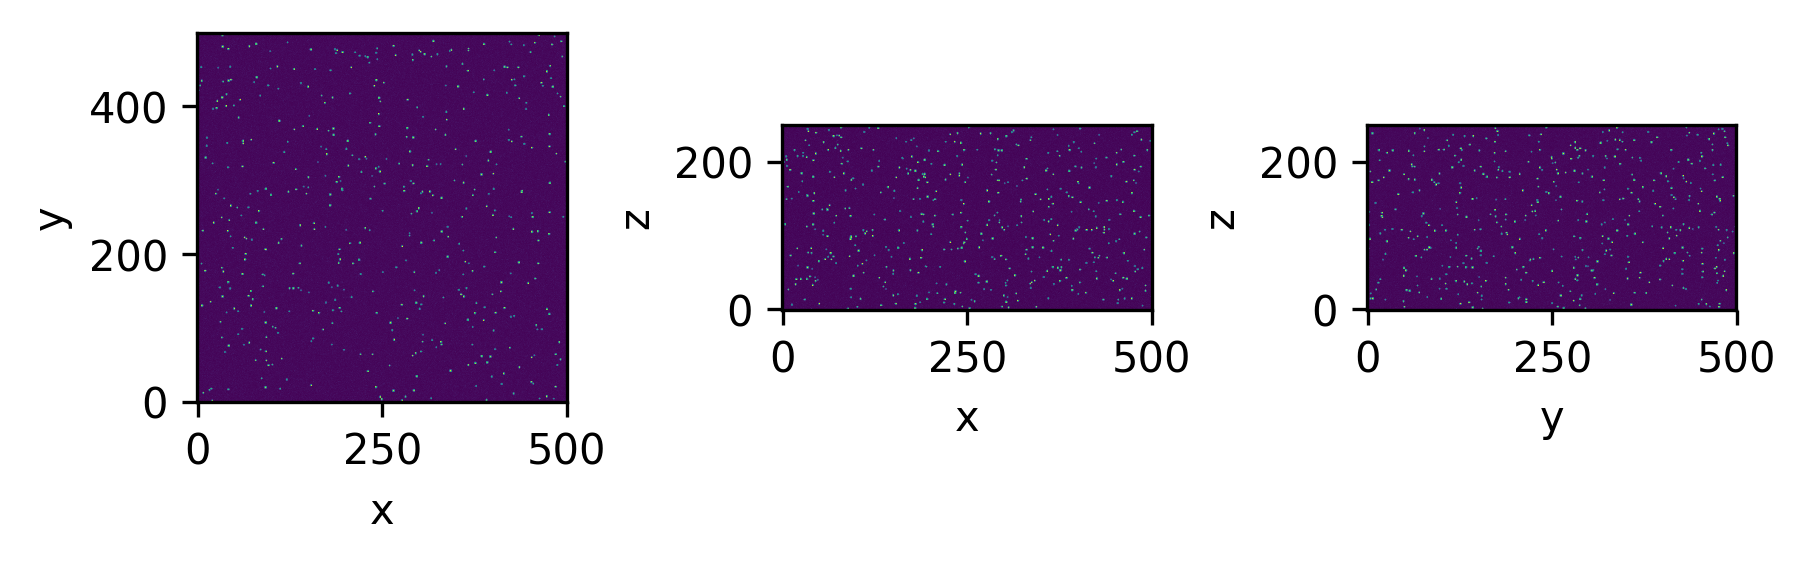

In [118]:
pl.maxIntensityProjection(X[0])

In [93]:
import skimage
import os
outputPath_tiff_prefix = './test__X_nonIsotropic_amp='+str(particle_kamp)+'_noise='+str(particle_kamp)+'_'
# this multiplier is necessary so that to prevent all the values being 0 when converting to int

multiplierForOutput = 2**16 #16 bit uint is the max value, so multiply all by that (otherwise you get 0 everywhere when converting to int)
for i in range(len(X)):
    outputPath_tiff = outputPath_tiff_prefix+str(i).zfill(2)+'.tiff'
    skimage.external.tifffile.imsave(outputPath_tiff_prefix+str(i).zfill(2)+'.tiff', (multiplierForOutput*X[i]).astype('uint16'))    
    print(os.path.abspath(outputPath_tiff))
    


#open the result in chimera X
# volume voxelSize 0.108,0.108,0.2

/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/createSimulatedData/test__X_nonIsotropic_amp=0.5_noise=0.5_00.tiff
